In [1]:
%matplotlib inline
import numpy as np
import sklearn
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import timeit
import pandas as pd
import math
import itertools
import time

from sklearn.neighbors import (
    KernelDensity,
    KDTree,
)
from sklearn.preprocessing import (
    RobustScaler
)

In [2]:
df_combined = pd.read_csv("../../data/room2.csv")

In [3]:
df_occ = df_combined[df_combined.Occupancy == 1]
df_un = df_combined[df_combined.Occupancy == 0]
dfo_sorted = df_occ.sort_values(by=['date'])

In [4]:
np.random.seed(0)
df_mixed = pd.concat([df_un,df_occ.sample(200, random_state=0)])
# df_mixed = pd.concat([df_un,dfo_sorted[:200]])
# df_mixed["Light"] = df_mixed["Light"] + np.random.rand(len(df_mixed))
# mixed_data = df_mixed[["Temperature", "Humidity", "CO2", "Light", "HumidityRatio"]].values
mixed_data = df_mixed[["Temperature", "CO2"]].values

In [5]:
def estimate_kde_bw(data):
    q3 = np.percentile(data, 75, axis=0)
    q1 = np.percentile(data, 25, axis=0)
    iqr = q3 - q1
    bw = iqr * (data.shape[0])**(-1.0/(data.shape[1]+4))
    return bw

In [6]:
bw = estimate_kde_bw(mixed_data)
norm_data = mixed_data / bw

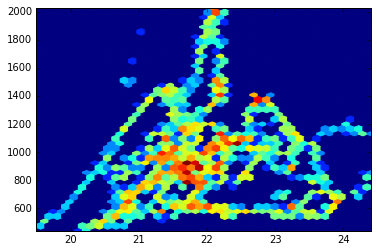

In [16]:
plt.hexbin(df_occ.Temperature, df_occ.CO2 ,gridsize=40,bins="log")

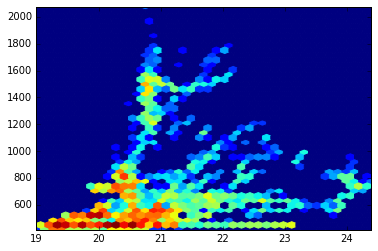

In [17]:
plt.hexbin(df_un.Temperature, df_un.CO2, gridsize=40,bins="log")

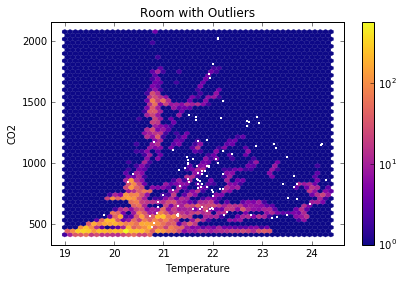

In [40]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.hexbin(df_un.Temperature, df_un.CO2, gridsize=50, linewidths=(.25,), norm=matplotlib.colors.LogNorm(), cmap='plasma')
plt.colorbar()
plt.xlabel("Temperature")
plt.ylabel("CO2")
plt.scatter(df_occ.Temperature[:100], df_occ.CO2[:100], marker=',', c='w', linewidth='0', s=2)
plt.title("Room with Outliers")
fig.tight_layout()
fig.savefig("Room_Outlier.pdf")

In [9]:
def eval_scores(df, scores):
    cutoff = np.percentile(scores, 99)
    outliers = scores > cutoff
    num_1 = sum(df[outliers])
    num_2 = sum(outliers)
    print("{}/{}".format(num_1, num_2))
    return outliers

# Bad Case

In [35]:
df_hard = pd.concat([df_un,dfo_sorted[:100]])

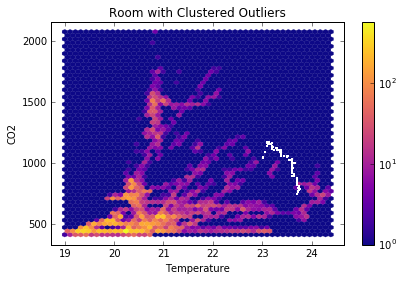

In [37]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.hexbin(df_un.Temperature, df_un.CO2, gridsize=50, linewidths=(.25,), norm=matplotlib.colors.LogNorm(), cmap='plasma')
plt.colorbar()
plt.xlabel("Temperature")
plt.ylabel("CO2")
plt.scatter(dfo_sorted.Temperature[:100], dfo_sorted.CO2[:100], marker=',', c='w', linewidth='0', s=2)
plt.title("Room with Clustered Outliers")
fig.tight_layout()
plt.savefig("hard_outliers.pdf")

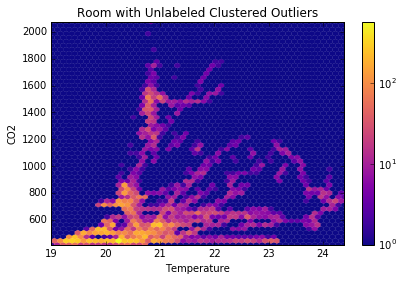

In [38]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.hexbin(df_hard.Temperature, df_hard.CO2, gridsize=50, linewidths=(.25,), norm=matplotlib.colors.LogNorm(), cmap='plasma')
plt.colorbar()
plt.xlabel("Temperature")
plt.ylabel("CO2")
plt.title("Room with Unlabeled Clustered Outliers")
fig.tight_layout()
plt.savefig("hard_outliers_unlabel.pdf")

# MCD

In [10]:
import sklearn.covariance

In [11]:
mcd = sklearn.covariance.MinCovDet(
    random_state=0,
)
mcd.fit(mixed_data)
mcd_scores = mcd.mahalanobis(mixed_data)
eval_scores(df_mixed.Occupancy, mcd_scores)

10/161


array([False, False, False, ...,  True, False, False], dtype=bool)

In [ ]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=math.log(mcd.mahalanobis([[X[i,j],Y[i,j]]])[0])
plt.contourf(X,Y,Z,100)
plt.colorbar()

# Emp Cov

In [11]:
import sklearn.covariance

In [12]:
mcd = sklearn.covariance.EmpiricalCovariance(
)
mcd.fit(mixed_data)
mcd_scores = mcd.mahalanobis(mixed_data)
outliers = eval_scores(df_mixed.Occupancy, mcd_scores)

13/161


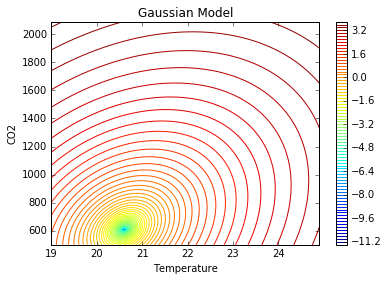

In [15]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=math.log(mcd.mahalanobis([[X[i,j],Y[i,j]]])[0])
plt.contour(X,Y,Z,100)
plt.colorbar()
plt.title("Gaussian Model")
plt.xlabel("Temperature")
plt.ylabel("CO2")
plt.savefig("empGauss.pdf")

# KDE

In [16]:
tol = .1
kde = KernelDensity(
    bandwidth=.25,
    kernel='gaussian',
    algorithm='kd_tree',
    rtol=tol,
)
bw = estimate_kde_bw(mixed_data)
norm_data = mixed_data / bw
kde.fit(norm_data)
kde_scores = kde.score_samples(norm_data)
outliers = eval_scores(df_mixed.Occupancy, -kde_scores)

98/161


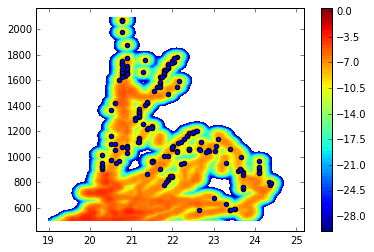

In [33]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=kde.score_samples([[X[i,j],Y[i,j]]] / bw)[0]
plt.figure()
plt.contourf(X,Y,Z,levels=np.arange(-30,1,.5))
plt.colorbar()
plt.scatter(mixed_data[outliers][:,0], mixed_data[outliers][:,1])

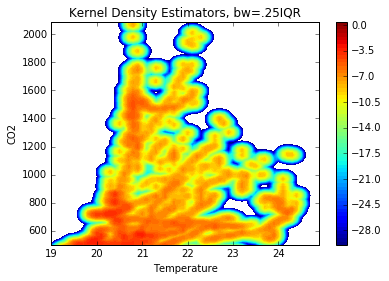

In [18]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=kde.score_samples([[X[i,j],Y[i,j]]] / bw)[0]
plt.figure()
plt.contourf(X,Y,Z,levels=np.arange(-30,1,.5))
plt.colorbar()
plt.title("Kernel Density Estimators, bw=.25IQR")
plt.xlabel("Temperature")
plt.ylabel("CO2")
plt.savefig("KDEcontour.pdf")

# GMM

In [14]:
import sklearn.mixture

In [25]:
np.random.seed(0)
gmm = sklearn.mixture.GaussianMixture(
    n_components=5,
    covariance_type="full",
    random_state=0,
)
gmm.fit(mixed_data)
gmm_scores = gmm.score_samples(mixed_data)
outliers = eval_scores(df_mixed.Occupancy, -gmm_scores)

47/161


In [34]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=gmm.score_samples([[X[i,j],Y[i,j]]])[0]
plt.figure()
plt.contour(X,Y,Z,100)
plt.colorbar()
plt.savefig("GMMContour.pdf")

# Random Forest

In [27]:
import sklearn.ensemble

In [28]:
forest = sklearn.ensemble.IsolationForest(
    contamination=.01,
    random_state=0,
)
forest.fit(mixed_data)
outliers = forest.predict(mixed_data) == -1
num_1 = sum(df_mixed.Occupancy[outliers])
num_2 = sum(outliers)
print("{}/{}".format(num_1, num_2))

35/161


# DBScan

In [26]:
import sklearn.cluster

In [29]:
dbs = sklearn.cluster.DBSCAN(
    eps=0.4,
    min_samples=4
)
clusters = dbs.fit_predict(norm_data)
outliers = (clusters == -1)
num_1 = sum(df_mixed.Occupancy[outliers])
num_2 = sum(outliers)
print("{}/{}".format(num_1, num_2))

92/150


# KNN

In [19]:
import sklearn.neighbors

In [20]:
tree = KDTree(
    norm_data
)

In [25]:
k=3
distances, _ = tree.query(norm_data, k=k)
knndistances = distances[:,k-1]
outliers = eval_scores(df_mixed.Occupancy, knndistances)

98/161


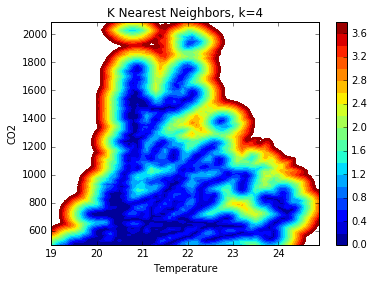

In [31]:
x = np.arange(19,25,.1)
y = np.arange(500,2100,10)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=tree.query([[X[i,j],Y[i,j]]] / bw, k=4)[0][0,3]
plt.figure()
plt.contourf(X,Y,Z,levels=np.arange(0,4,.2))
plt.colorbar()
plt.title("K Nearest Neighbors, k=4")
plt.xlabel("Temperature")
plt.ylabel("CO2")
plt.savefig("KNNcontour.pdf")